# trans_ra2ll - Transform trans.dat from Radar to Geographic Coordinates

trans.dat    - file generated by llt_grid2rat  (r a topo lon lat)"

In [1]:
import sys
!{sys.executable} -m pip install xarray numpy dask scipy matplotlib --upgrade

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree

In [3]:
# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Read (range, azimuth, topo, lon, lat) file

In [4]:
trans = np.fromfile('asc/topo/trans.dat', dtype=np.float64).reshape([-1,5])

In [5]:
trans.shape

(13728190, 5)

In [6]:
lon_min, lon_max = trans[:,3].min(),trans[:,3].max()

In [7]:
lat_min, lat_max = trans[:,4].min(),trans[:,4].max()

## Read lat-lon grid

In [8]:
dem = xr.open_dataset('asc/topo/dem.grd')['Band1']\
    .rename('z')\
    .sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))
dem

<xarray.DataArray 'z' (lat: 3320, lon: 5745)>
[19073400 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 37.8 37.8 37.8 37.8 37.8 ... 38.46 38.46 38.47 38.47
  * lon      (lon) float64 47.73 47.73 47.73 47.73 ... 48.88 48.88 48.88 48.88
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

## Calculate trans.dat Transform to DEM

In [9]:
%%time
trans_latlons = np.stack([trans[:,4],trans[:,3]], axis=1)
trans_latlons[0]

CPU times: user 154 ms, sys: 70.6 ms, total: 224 ms
Wall time: 235 ms


array([38.4653  , 48.764069])

In [10]:
%%time
dem_lats, dem_lons = xr.broadcast(dem.lat,dem.lon)
dem_latlons = np.stack([dem_lats.values.reshape(-1),dem_lons.values.reshape(-1)], axis=1)
dem_latlons[0]

CPU times: user 255 ms, sys: 251 ms, total: 506 ms
Wall time: 844 ms


array([37.8015, 47.7299])

In [11]:
%%time
tree = cKDTree(trans_latlons, compact_nodes=False, balanced_tree=False)

CPU times: user 1.8 s, sys: 180 ms, total: 1.98 s
Wall time: 2.03 s


In [12]:
#distance_limit = np.sqrt(dem.lat.diff('lat')[0]**2 + dem.lon.diff('lon')[0]**2)
distance_limit = np.max([dem.lat.diff('lat')[0],dem.lon.diff('lon')[0]])
distance_limit

0.00019999999999953388

In [13]:
%%time
d, inds = tree.query(dem_latlons, k = 1, distance_upper_bound=distance_limit, workers=8)

CPU times: user 38.9 s, sys: 312 ms, total: 39.3 s
Wall time: 11.8 s


In [14]:
%%time
# produce the same output array as dataset to be able to add global attributes
trans_ra2ll = xr.zeros_like(dem).rename('trans_ra2ll')
trans_ra2ll.values = np.where(~np.isinf(d), inds, -1).reshape(dem.shape)

CPU times: user 895 ms, sys: 139 ms, total: 1.03 s
Wall time: 1.05 s


In [15]:
%%time
compression = dict(zlib=True, complevel=3, chunksizes=[512,512])
# magic: add GMT attribute to prevent coordinates shift for 1/2 pixel
trans_ra2ll.attrs['node_offset'] = np.int32(1)
trans_ra2ll.to_netcdf('asc/topo/trans_ra2ll.grd', encoding={'trans_ra2ll': compression})

CPU times: user 592 ms, sys: 38.4 ms, total: 631 ms
Wall time: 650 ms


## Cleanup

In [16]:
del trans, tree, d, inds, trans_latlons, dem_latlons, trans_ra2ll

## Read data file and transform

In [17]:
%%time
trans = np.fromfile('asc/topo/trans.dat', dtype=np.float64).reshape([-1,5])

CPU times: user 1.49 ms, sys: 366 ms, total: 368 ms
Wall time: 460 ms


In [18]:
%%time
trans_ra2ll = xr.open_dataarray('asc/topo/trans_ra2ll.grd')
trans_ra2ll

CPU times: user 5.9 ms, sys: 2.48 ms, total: 8.38 ms
Wall time: 8.88 ms


<xarray.DataArray 'trans_ra2ll' (lat: 3320, lon: 5745)>
[19073400 values with dtype=int64]
Coordinates:
  * lat      (lat) float64 37.8 37.8 37.8 37.8 37.8 ... 38.46 38.46 38.47 38.47
  * lon      (lon) float64 47.73 47.73 47.73 47.73 ... 48.88 48.88 48.88 48.88
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs
    node_offset:   1

In [19]:
%%time
# only to show on the map below
dem = xr.open_dataset('asc/topo/dem.grd')['Band1']\
    .rename('z').coarsen({'lat':8,'lon':8}).mean()
dem

CPU times: user 5.16 s, sys: 2.99 s, total: 8.16 s
Wall time: 11.9 s


<xarray.DataArray 'z' (lat: 1500, lon: 2250)>
array([[1714.7031  , 1714.1875  , 1725.2969  , ...,  -13.      ,
         -13.6875  ,  -14.625   ],
       [1711.1094  , 1713.0625  , 1718.5312  , ...,  -13.125   ,
         -14.109375,  -14.796875],
       [1708.6406  , 1710.3438  , 1717.1562  , ...,  -14.125   ,
         -12.640625,  -12.75    ],
       ...,
       [1571.625   , 1532.75    , 1502.125   , ..., -225.45312 ,
        -227.54688 , -206.21875 ],
       [1517.0781  , 1488.6562  , 1462.7188  , ..., -223.04688 ,
        -225.14062 , -204.09375 ],
       [1547.7969  , 1513.6094  , 1493.2344  , ..., -220.6875  ,
        -222.75    , -202.03125 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 37.3 37.3 37.3 37.31 37.31 ... 39.69 39.7 39.7 39.7
  * lon      (lon) float64 46.4 46.4 46.4 46.41 46.41 ... 49.99 50.0 50.0 50.0
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

## Apply transform

In [20]:
%%time
topo_ll = xr.DataArray(np.where(trans_ra2ll>=0, trans[:,2][trans_ra2ll], np.nan), coords=trans_ra2ll.coords)

CPU times: user 533 ms, sys: 642 ms, total: 1.18 s
Wall time: 1.2 s


## Plot

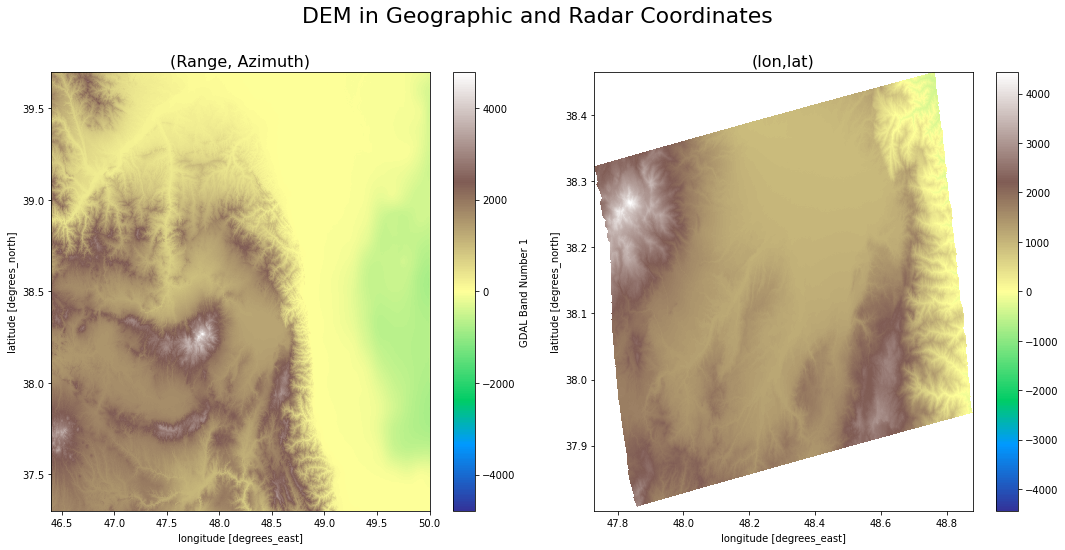

CPU times: user 10.7 s, sys: 802 ms, total: 11.5 s
Wall time: 11.5 s


In [21]:
%%time

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('(Range, Azimuth)',fontsize=16)

topo_ll.plot(ax=ax2, cmap='terrain')
ax2.set_title('(lon,lat)',fontsize=16)

plt.suptitle(f'DEM in Geographic and Radar Coordinates', fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.show()